# 📱 **Google Play Store Apps Analysis**

**Author:** Dhaara Thakkar   

## 📌 Project Objective

To clean, transform, and analyze the Google Play Store dataset and uncover insights about app ratings, categories, installs, and pricing.

## 🧾 Step 1: Import Libraries

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 📂 Step 2: Load the Dataset

In [7]:
df = pd.read_csv(r"C:\Users\Admin\Documents\Projects\Google Play Store Apps\googleplaystore.csv") #Update path as needed

In [8]:
df.shape

(10841, 13)

In [9]:
df.head().style

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.100000,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.900000,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide Apps",ART_AND_DESIGN,4.700000,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.500000,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.300000,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


## 🧼 Step 3: Data Cleaning

### 🔹 3.1: Initial Overview

In [12]:
print(df.describe())

            Rating
count  9367.000000
mean      4.193338
std       0.537431
min       1.000000
25%       4.000000
50%       4.300000
75%       4.500000
max      19.000000


**Observation:**  
The maximum rating is 19.0 — but ratings on the Play Store should only go up to 5.

✅ **Action Taken:**  
Dropped the row using its index.

In [14]:
print(df[df['Rating'] == 19].index)

Index([10472], dtype='int64')


In [15]:
df = df.drop(df[df['Rating'] == 19].index)

### 🔹 3.2: Data Types & Structure

In [17]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 10840 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10840 non-null  object 
 1   Category        10840 non-null  object 
 2   Rating          9366 non-null   float64
 3   Reviews         10840 non-null  object 
 4   Size            10840 non-null  object 
 5   Installs        10840 non-null  object 
 6   Type            10839 non-null  object 
 7   Price           10840 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10840 non-null  object 
 10  Last Updated    10840 non-null  object 
 11  Current Ver     10832 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.2+ MB
None


In [18]:
df['Installs'] = df['Installs'].str.replace('[+,]', '', regex = True).astype(int)

In [19]:
df['Price'] = df['Price'].str.replace('$', '', regex=False).astype(float)

In [20]:
df['Reviews'] = df['Reviews'].astype(int)

### 🔹 3.3: Duplicate Values

In [22]:
print(f"Duplicate rows: {df.duplicated().sum()}")

Duplicate rows: 483


In [23]:
df.drop_duplicates(inplace=True)

### 🔹 3.4: Missing Values

#### Handling Missing Values in Rating

In [26]:
print(df.isnull().sum())

App                  0
Category             0
Rating            1465
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       0
Genres               0
Last Updated         0
Current Ver          8
Android Ver          2
dtype: int64


We noticed several missing values in the `Rating` column.  
Instead of dropping them, we filled them using the **mean rating of similar apps grouped by binned `Installs`**.

To do that, we first created an `Installs_category` column:

In [28]:
bins = [-1, 0, 10, 1000, 10000, 100000, 1000000, 10000000, 10000000000]
labels = ['no', 'Very low', 'Low', 'Moderate', 'More than moderate', 'High', 'Very high', 'Top Notch']
df['Installs_category'] = pd.cut(df['Installs'], bins = bins, labels  = labels)

Then, we filled the missing values in `Rating` using the **grouped mean** of these install categories:

In [30]:
df['Rating'] = df.groupby('Installs_category', observed = True)['Rating'].transform(lambda x: x.fillna(x.mean()))

In [31]:
print(df.isnull().sum())

App                   0
Category              0
Rating               15
Reviews               0
Size                  0
Installs              0
Type                  1
Price                 0
Content Rating        0
Genres                0
Last Updated          0
Current Ver           8
Android Ver           2
Installs_category     0
dtype: int64


After filling missing values in the `Rating` column using group-wise means from `Installs_category`,  
we found that **15 rows still had NaN values** in `Rating`.

We found that these remaining rows all fell under the 'no' install category — i.e., apps with 0 installs.

In [34]:
df[df['Rating'].isna()]['Installs_category'].value_counts()

Installs_category
no                    15
Very low               0
Low                    0
Moderate               0
More than moderate     0
High                   0
Very high              0
Top Notch              0
Name: count, dtype: int64

In [35]:
df[(df['Installs_category'] == 'no') & (df['Rating'].isna())]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Installs_category
4465,Popsicle Launcher for Android P 9.0 launcher,PERSONALIZATION,NaN,0,5.5M,0,Paid,1.49,Everyone,Personalization,"July 11, 2018",1.1,4.2 and up,no
5307,Ak Parti Yardım Toplama,SOCIAL,NaN,0,8.7M,0,Paid,13.99,Teen,Social,"July 28, 2017",3.4.4.3.3,4.1 and up,no
5486,AP Series Solution Pro,FAMILY,NaN,0,7.4M,0,Paid,1.99,Everyone,Education,"July 30, 2017",1.3,4.0 and up,no
5945,Ain Arabic Kids Alif Ba ta,FAMILY,NaN,0,33M,0,Paid,2.99,Everyone,Education,"April 15, 2016",1.0,3.0 and up,no
6692,cronometra-br,PRODUCTIVITY,NaN,0,5.4M,0,Paid,154.99,Everyone,Productivity,"November 24, 2017",1.0.0,4.1 and up,no
7434,Pekalongan CJ,SOCIAL,NaN,0,5.9M,0,Free,0.00,Teen,Social,"July 21, 2018",0.0.1,4.4 and up,no
8081,CX Network,BUSINESS,NaN,0,10M,0,Free,0.00,Everyone,Business,"August 6, 2018",1.3.1,4.1 and up,no
8614,Sweden Newspapers,NEWS_AND_MAGAZINES,NaN,0,2.1M,0,Free,0.00,Everyone,News & Magazines,"July 7, 2018",1.1,4.4 and up,no
8871,Test Application DT 02,ART_AND_DESIGN,NaN,0,1.2M,0,Free,0.00,Everyone,Art & Design,"March 14, 2017",4.0,4.2 and up,no
9148,Command & Conquer: Rivals,FAMILY,NaN,0,Varies with device,0,NaN,0.00,Everyone 10+,Strategy,"June 28, 2018",Varies with device,Varies with device,no


Since apps with 0 installs are not used or rated by anyone, they offer no analytical value,
so we decided to drop these rows from the dataset.

In [37]:
df = df[df['Installs'] > 0]

#### Handling Missing Values in Other Columns

In [39]:
df.dropna(subset=['Current Ver', 'Android Ver', 'Type'],inplace = True)

In [40]:
print(df.isnull().sum())

App                  0
Category             0
Rating               0
Reviews              0
Size                 0
Installs             0
Type                 0
Price                0
Content Rating       0
Genres               0
Last Updated         0
Current Ver          0
Android Ver          0
Installs_category    0
dtype: int64


## 🔄 Step 4: Feature Engineering

### 🔹 Create Size_MB Feauture from Raw 'Size' Column

The `Size` column originally contains inconsistent string values like `"19M"`, `"14k"`, and `"Varies with device"`.  
To analyze app sizes effectively, we converted these to numeric format in **bytes**, and then to **megabytes (MB)** for readability.

✅ This makes the data usable for comparisons, distributions, and visualizations.

In [43]:
df['Size'].value_counts()

Size
Varies with device    1525
11M                    187
12M                    186
13M                    186
14M                    181
                      ... 
721k                     1
430k                     1
429k                     1
200k                     1
619k                     1
Name: count, Length: 457, dtype: int64

In [44]:
def convert_size_to_bytes(size):
    if isinstance(size, str):
        if 'k' in size:
            return float(size.replace("k", "")) * 1024
        elif 'M' in size:
            return float(size.replace("M", "")) * 1024 * 1024
        elif 'Varies with device' in size:
            return np.nan
    return size

df['Size_in_bytes'] = df['Size'].apply(convert_size_to_bytes)
df['Size_MB'] = df['Size_in_bytes'] / (1024 * 1024)

We earlier created `Installs_category` for imputation,  
but it also helps simplify analysis and visualize trends across install ranges.

In [46]:
df.to_csv('C:/Users/Admin/Documents/Projects/googleplaystore_cleaned.csv', index=False)

## 📊 Step 5: Exploratory Data Analysis

### 🔹 Distribution of Ratings

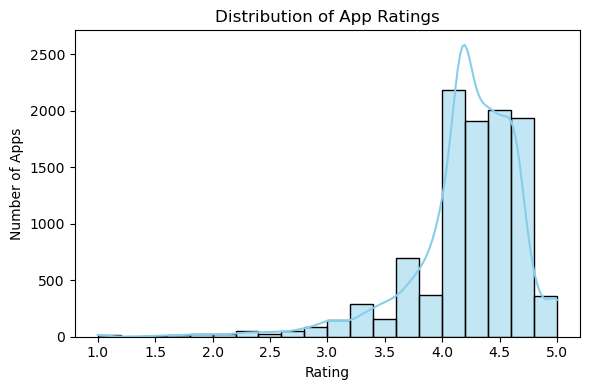

In [49]:
plt.figure(figsize=(6, 4))  
sns.histplot(df['Rating'], bins=20, kde=True, color='skyblue', edgecolor='black')

plt.title("Distribution of App Ratings")
plt.xlabel("Rating")
plt.ylabel("Number of Apps")  

plt.tight_layout()
plt.show()

### 🔹 Most Common Categories

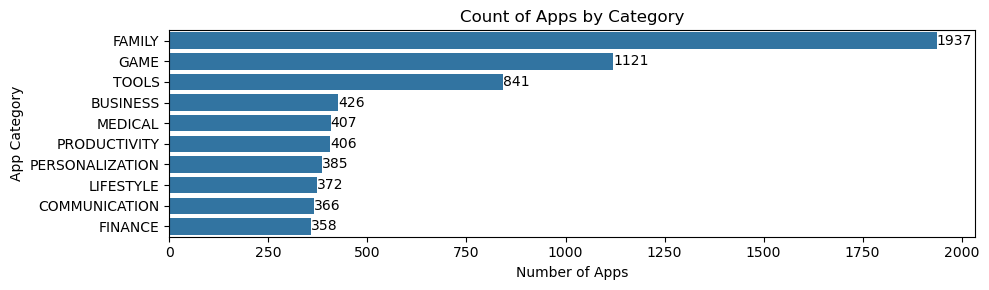

In [51]:
plt.figure(figsize=(10, 3))
ax = sns.countplot(y='Category', data=df, order=df['Category'].value_counts().head(10).index)

ax.bar_label(ax.containers[0], label_type='edge')  

plt.title("Count of Apps by Category")
plt.xlabel("Number of Apps")
plt.ylabel("App Category")
plt.tight_layout()
plt.show()

### 🔹 Free vs Paid Apps

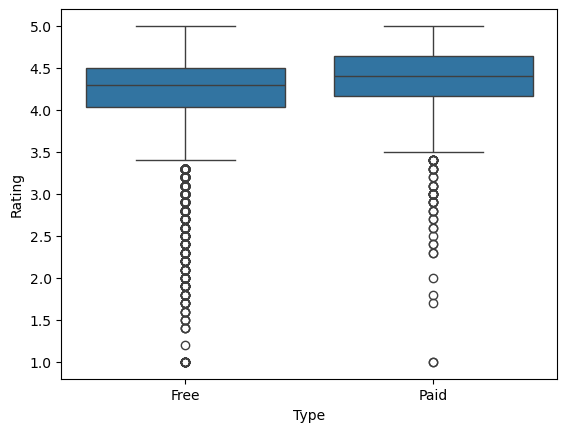

In [53]:
sns.boxplot(x='Type', y='Rating', data=df)
plt.show()

### 🔹 Top Apps with 1B+ Installs — Ranked by User Engagement

Google Play reports installs in ranges like 10K, 100K, 1M, 10M, etc.  
As a result, many apps have the **same install count**.

For example, over **1,400 apps have 1M installs**, and nearly **1,000 apps have 10M installs**.

In [56]:
df['Installs'].value_counts().head()

Installs
1000000     1487
10000000    1132
100000      1129
10000       1031
1000         888
Name: count, dtype: int64

In [57]:
top_installs = df[df['Installs'] == df['Installs'].max()]

To identify the "top apps," we used the **number of reviews** as a secondary metric.

In [59]:
top_apps = top_installs.sort_values(by='Reviews', ascending=False)

Below are the top 5 apps in the highest install tier, sorted by review count.

In [61]:
top_apps[['App', 'Installs', 'Reviews', 'Rating']].head(5)

,App,Installs,Reviews,Rating
2544,Facebook,1000000000,78158306,4.1
3943,Facebook,1000000000,78128208,4.1
336,WhatsApp Messenger,1000000000,69119316,4.4
3904,WhatsApp Messenger,1000000000,69109672,4.4
2604,Instagram,1000000000,66577446,4.5


# 📌 Key Metrics

### 🔹 Top 5 Most Common App Genres

In [64]:
df['Genres'].value_counts().head(5)

Genres
Tools            840
Entertainment    587
Education        524
Business         426
Medical          407
Name: count, dtype: int64

**A high count in a genre like 'Tools' or 'Entertainment' might indicate market saturation, while also showing developer interest in those areas.**

### 🔹 Top 5 App Categories by Total Installs

In [67]:
df.groupby('Category')['Installs'].sum().sort_values(ascending=False).head()

Category
GAME             31544024415
COMMUNICATION    24152276251
SOCIAL           12513867902
PRODUCTIVITY     12463091369
TOOLS            11452271905
Name: Installs, dtype: int64

**"The 'GAME' and 'COMMUNICATION' categories lead in total installs, suggesting a high demand for entertainment and social connectivity apps."**

### 🔹 Top 5 App Categories by Total Number of Reviews

In [70]:
df.groupby('Category')['Reviews'].sum().sort_values(ascending=False).head()

Category
GAME             1415536650
COMMUNICATION     601273552
SOCIAL            533576829
FAMILY            396771746
TOOLS             273181033
Name: Reviews, dtype: int32

**"Categories like 'GAME' and 'COMMUNICATION' not only lead in installs but also reviews, suggesting active user engagement beyond just downloads."**



## 🔍 Final Thoughts

Overall, the data shows that app categories like 'GAME' and 'COMMUNICATION' dominate in both installs and user engagement. Combined with genre frequency, these insights offer a snapshot of current market trends and user interests in the Google Play ecosystem.

## What These Insights Could Be Used For:

These insights could help app developers or marketers focus on high-demand categories, understand user behavior, and identify saturated genres to either innovate in or avoid.

## Limitations:

- Data may be outdated or limited in scope.
- Some values (e.g., installs, ratings) may not be up-to-date or normalized.

## Next Steps:

- Explore ratings vs. installs to check satisfaction levels.
- Perform sentiment analysis on user reviews (if review text available).
- Cluster similar genres for better insights.